In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Lambda, GRU
from keras.layers.core import Masking, Reshape
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import adam

import matrnn_objective as obj
import matrnn_distributional as dist
from TSSparse import TSSparse

Using TensorFlow backend.


In [2]:
np.random.seed(520680)

We'll generate a sequence of fixed-length arrivals for this demo.

In [3]:
ntime = 100
nev = 4 
nobs = 1000

miniat = 3
maxiat = 18
iat = np.linspace(miniat, maxiat, nev)
print ('inter-arrival times:', iat)

inter-arrival times: [ 3.  8. 13. 18.]


For truth matrix, we require `y` matrix of shape has shape
	`(n_observations, n_sequence, n_eventtypes, 4)`.
The last axis contains all the arrival-time information for the process you want to model
	`4 = length((tse, tte, unc, purchstatus))`.

- `tse(t)` is time since previous event if `purchstatus(t)==1` and time since start if otherwise
- `tte(t)` is time to next event if `unc(t)==1` and time to end of training if otherwise
- `unc(t)` is `1` if next event is observed by end of training and `0` otherwise
- `purchstatus(t)` is `1` if first event has occurred and `0` otherwise

In [4]:
# set up indicator vector for event arrival
yind = np.zeros((nobs, nev, ntime))
# observations start with delays
delays = np.arange(maxiat)

# 3 loops is not good for healthy but is good for read
for i in range(nobs):
    delaytemp = delays[i % len(delays)]
    for k in range(nev):
        t = int(delaytemp)
        while t < ntime:
            yind[i, k, t] = 1
            t += int(iat[k])

In [5]:
ytstfsall = [TSSparse(yind[obsno, ...]).transformations() for obsno in range(nobs)]

In [6]:
obsno = 5

indicators


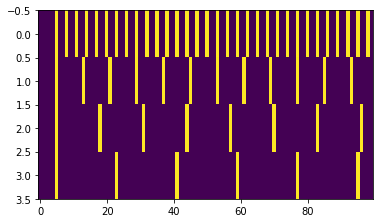

time_since_event


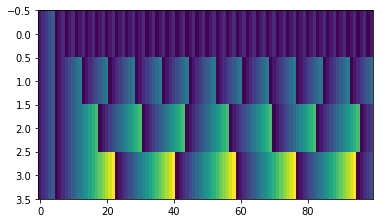

time_to_event


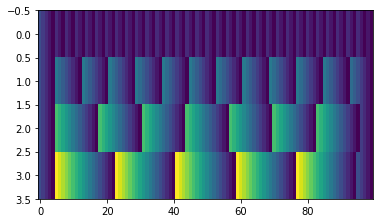

is_uncensored


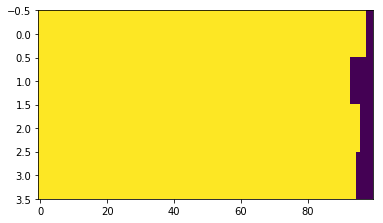

is_notfirstrodeo


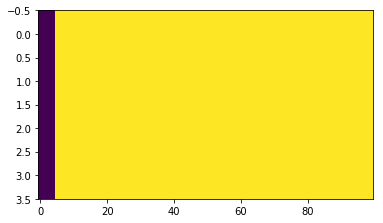

In [7]:
print ('indicators')
plt.imshow(yind[obsno, :, :], aspect=9/16*ntime/nev)
plt.show()

print ('time_since_event')
plt.imshow(ytstfsall[obsno]['time_since_event'], aspect=9/16*ntime/nev)
plt.show()

print ('time_to_event')
plt.imshow(ytstfsall[obsno]['time_to_event'], aspect=9/16*ntime/nev)
plt.show()

print ('is_uncensored')
plt.imshow(ytstfsall[obsno]['is_uncensored'], aspect=9/16*ntime/nev)
plt.show()

print ('is_notfirstrodeo')
plt.imshow(ytstfsall[obsno]['is_notfirstrodeo'], aspect=9/16*ntime/nev)
plt.show()

In [8]:
# tse, tte, unc, purchstatus
shapetemp = (nev, ntime, 1)
y = np.concatenate(
    [np.concatenate(
        [temp['time_since_event'].reshape(shapetemp), 
         temp['time_to_event'].reshape(shapetemp),
         temp['is_uncensored'].reshape(shapetemp), 
         temp['is_notfirstrodeo'].reshape(shapetemp)], 
        axis=-1).reshape((1, nev, ntime, 4)) 
     for temp in ytstfsall], 
    axis=0)

In [9]:
# rearrange (obsdex, evdex, timedex, ...) to (obsdex, timedex, evdex, ...)
y = np.swapaxes(y, 1, 2)

In [10]:
x = y[:, :, :, [0]].reshape((nobs, ntime, nev))

In [11]:
# this should be sample average of all observed inter-arrival times (average over event times as well)
# but here we cheat because we already know this
iniscale=np.mean(iat)
print (iniscale)

10.5


In [12]:
w = 2*nev
print ('w:', w)

model = Sequential()
model.add(GRU(w, return_sequences=True, dropout=.2, input_shape=(None, x.shape[-1])))
model.add(GRU(w, return_sequences=True, dropout=.2))
model.add(Dense(2*nev, activation='tanh'))
model.add(TimeDistributed(Reshape((nev, 2))))
model.add(Lambda(obj.activation, arguments={"iniscale": iniscale}))

loss = obj.ExcessConditionalLoss(iswtte=True).loss
model.compile(loss=loss, optimizer=adam(lr=.01, clipvalue=5.))
print (model.summary())

w: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 8)           312       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 8)           408       
_________________________________________________________________
dense_1 (Dense)              (None, None, 8)           72        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 4, 2)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 4, 2)        0         
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
history = model.fit(x, y, batch_size=256, epochs=100)

Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 9.2676
Epoch 2/100
1000/1000 [==============================] - 1s 552us/step - loss: 8.8104
Epoch 3/100
1000/1000 [==============================] - 1s 568us/step - loss: 8.5546
Epoch 4/100
1000/1000 [==============================] - 1s 571us/step - loss: 8.3792
Epoch 5/100
1000/1000 [==============================] - 1s 513us/step - loss: 8.2425
Epoch 6/100
1000/1000 [==============================] - 1s 583us/step - loss: 8.1392
Epoch 7/100
1000/1000 [==============================] - 1s 554us/step - loss: 8.0838
Epoch 8/100
1000/1000 [==============================] - 1s 577us/step - loss: 8.0296
Epoch 9/100
1000/1000 [==============================] - 1s 534us/step - loss: 7.9595
Epoch 10/100
1000/1000 [==============================] - 1s 551us/step - loss: 7.9231
Epoch 11/100
1000/1000 [==============================] - 0s 491us/step - loss: 7.8753
Epoch 12/100
1000/1000 [==============================

1000/1000 [==============================] - 1s 649us/step - loss: 6.6547
Epoch 96/100
1000/1000 [==============================] - 1s 553us/step - loss: 6.6461
Epoch 97/100
1000/1000 [==============================] - 1s 554us/step - loss: 6.6455
Epoch 98/100
1000/1000 [==============================] - 1s 624us/step - loss: 6.6597
Epoch 99/100
1000/1000 [==============================] - 1s 639us/step - loss: 6.6696
Epoch 100/100
1000/1000 [==============================] - 1s 681us/step - loss: 6.6455


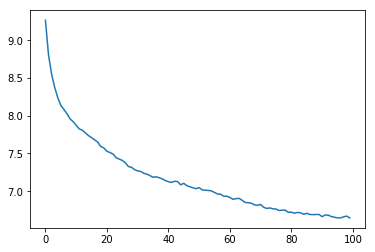

In [14]:
plt.plot(history.history['loss'])
plt.show()

In [15]:
pred = model.predict(x)
print (pred.shape)

(1000, 100, 4, 2)


In [16]:
q25 = dist.quantile(elapsed=y[..., 0], p=.25, scale=pred[..., 0], shape=pred[..., 1])
q50 = dist.quantile(elapsed=y[..., 0], p=.50, scale=pred[..., 0], shape=pred[..., 1])
q75 = dist.quantile(elapsed=y[..., 0], p=.75, scale=pred[..., 0], shape=pred[..., 1])

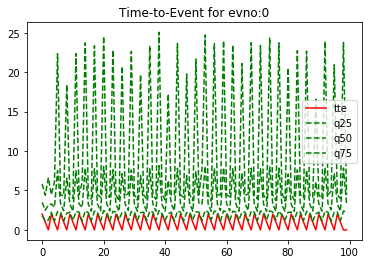

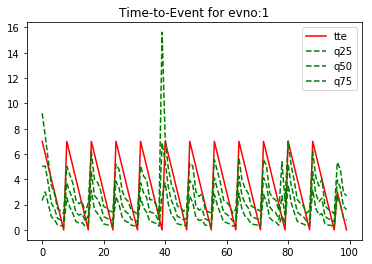

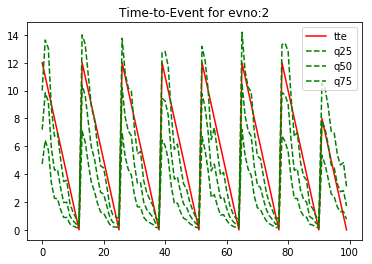

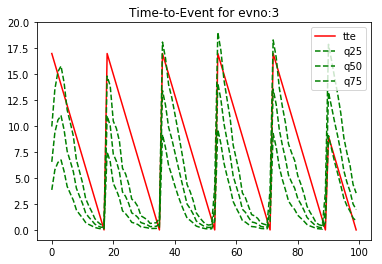

In [17]:
obsno = 0

for evno in range(nev):
    plt.plot(y[obsno, :, evno, 1], color='red', label='tte')
    plt.plot(q25[obsno, :, evno], color='green', label='q25', ls='--')
    plt.plot(q50[obsno, :, evno], color='green', label='q50', ls='--')
    plt.plot(q75[obsno, :, evno], color='green', label='q75', ls='--')
    plt.title('Time-to-Event for evno:' + str(evno))
    plt.legend()
    plt.show()

# Notes

`tte` for the last step is computed as time to end of training period.

Even though the predicted quantiles do not exactly follow the true time-to-event, it does approach 0 as we get closer to the occurence of the next event. Note that `tte` is not a covariate and thus this is desirable.

## Frequently occuring events

For frequently occurring events like the one that occurs every 2 time units, prediction is poor. If you're trying to predict high-frequency events (i.e. counts of arrivals per unit time is not sparse), an intensity-based model (i.e. point process model) might work better.

## Single initial scale factor

Currently this implementation takes in a single initial scale that is fed into activation function. The single scale is the average observed inter-arrival time over all event types. Having multiple scale factor for each event type may improve estimates.